In [1]:
%matplotlib inline
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, Flatten, Dropout
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import TensorBoard
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py

C:\Users\ybercovich\PycharmProjects\mta_machinelearning\venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



In [3]:
# size of images is 32x32x3
x_train.shape
y_train.shape

(50000, 1)

### show random image. (2 was selected randomly https://xkcd.com/221/)

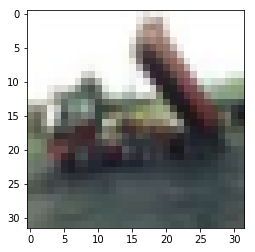

In [4]:
img = x_train[2,:,:,:]
plt.imshow(img,cmap='gray')


## Normalize the data 

In [5]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


### Noise the image

In [6]:

noise_factor = 0.1
train_noise_mask = np.random.choice([0,1], size=x_train.shape, p=[1-noise_factor, noise_factor])
test_noise_mask  = np.random.choice([0,1], size=x_test.shape,  p=[1-noise_factor, noise_factor])
x_train_noisy = x_train + np.multiply(train_noise_mask, np.random.normal(loc=0.0, scale=1.0, size=x_train.shape))
x_test_noisy = x_test   + np.multiply(test_noise_mask, np.random.normal(loc=0.0, scale=1.0, size=x_test.shape))


# make sure that the noise did not take use above 1 or below 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)



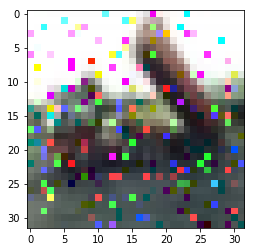

In [7]:
# let's see how it looks:

img = x_train_noisy[2,:,:,:]
plt.imshow(img)


In [8]:


def train_model():
    input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format
    print ("input_img:", input_img.shape)
    
    x = Conv2D(16, (2, 2), activation='relu', padding='same', name='conv1')(input_img)
    x = MaxPooling2D((2, 2), padding='same', name='maxpool1')(x)
    x = Conv2D(8, (2, 2), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), padding='same', name='maxpool2')(x)
    encoded = x # MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    print ("encoded:", encoded.shape)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    
    x = UpSampling2D((2, 2), name='upsample1')(encoded)    
    x = Conv2D(8, (2, 2), activation='relu', padding='same', name='conv3')(x)
    x = UpSampling2D((2, 2), name='upsample2')(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same', name='conv4')(x)
    print ("x", x.shape)    
    decoded = Conv2D(3, (2, 2), activation='sigmoid', padding='same', name='conv_sig')(x)
    print ("decoded:", decoded.shape)
    


    autoencoder = Model(input_img, decoded)
    #optimizer = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    optimizer = optimizers.Adam()
    autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

    autoencoder.fit(x_train_noisy, x_train,
                    epochs=200,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[TensorBoard(log_dir='c:\\temp\\tb_', histogram_freq=0, write_graph=False)])

    autoencoder.save('autoencoder_binary_crossentropy.h5')
    autoencoder.save_weights('my_model_weights_binary_crossentropy.h5')
    print ("model saved")

train_model()

input_img: (?, 32, 32, 3)
encoded: (?, 8, 8, 8)
x (?, 32, 32, 16)
decoded: (?, 32, 32, 3)
Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 93s 2ms/step - loss: 0.6047 - val_loss: 0.5846
Epoch 2/200
50000/50000 [==============================] - 91s 2ms/step - loss: 0.5810 - val_loss: 0.5799
Epoch 3/200
50000/50000 [==============================] - 91s 2ms/step - loss: 0.5780 - val_loss: 0.5779
Epoch 4/200
50000/50000 [==============================] - 91s 2ms/step - loss: 0.5764 - val_loss: 0.5767
Epoch 5/200
50000/50000 [==============================] - 90s 2ms/step - loss: 0.5750 - val_loss: 0.5754
Epoch 6/200
50000/50000 [==============================] - 90s 2ms/step - loss: 0.5740 - val_loss: 0.5745
Epoch 7/200
50000/50000 [==============================] - 90s 2ms/step - loss: 0.5733 - val_loss: 0.5739
Epoch 8/200
50000/50000 [==============================] - 92s 2ms/step - loss: 0.5728 - val_loss: 0.5735
Epoch 9/200


50000/50000 [==============================] - 87s 2ms/step - loss: 0.5669 - val_loss: 0.5678
Epoch 77/200
50000/50000 [==============================] - 87s 2ms/step - loss: 0.5669 - val_loss: 0.5677
Epoch 78/200
50000/50000 [==============================] - 86s 2ms/step - loss: 0.5669 - val_loss: 0.5677
Epoch 79/200
50000/50000 [==============================] - 86s 2ms/step - loss: 0.5668 - val_loss: 0.5677
Epoch 80/200
50000/50000 [==============================] - 87s 2ms/step - loss: 0.5668 - val_loss: 0.5677
Epoch 81/200
50000/50000 [==============================] - 88s 2ms/step - loss: 0.5668 - val_loss: 0.5677
Epoch 82/200
50000/50000 [==============================] - 89s 2ms/step - loss: 0.5668 - val_loss: 0.5676
Epoch 83/200
50000/50000 [==============================] - 91s 2ms/step - loss: 0.5668 - val_loss: 0.5676
Epoch 84/200
50000/50000 [==============================] - 89s 2ms/step - loss: 0.5667 - val_loss: 0.5676
Epoch 85/200
50000/50000 [========================

50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5671
Epoch 153/200
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5670
Epoch 154/200
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5670
Epoch 155/200
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5670
Epoch 156/200
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5670
Epoch 157/200
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5670
Epoch 158/200
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5670
Epoch 159/200
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5671
Epoch 160/200
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5662 - val_loss: 0.5671
Epoch 161/200
50000/50000 [===============

#### Test auto encoder performance

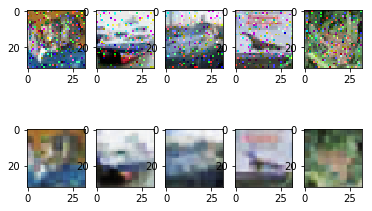

In [9]:
# lets test its performance:
autoencoder = load_model('autoencoder_binary_crossentropy.h5')
output = autoencoder.predict( x_test_noisy[:5, :, :, :] )
test_imges = x_test_noisy[:5, :, :, :]
fig,axes = plt.subplots(nrows = 2, ncols = 5)
for i in range(5):
    axes[0,i].imshow(test_imges[i,:,:,:])
    axes[1,i].imshow(output[i,:,:,:])

plt.show()

## now create a regular convulotional network

In [35]:

def train_model():
    
    input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format
    print ("input_img:", input_img.shape)
    
    x = Conv2D(16, (2, 2), activation='relu', padding='same', name='conv1')(input_img)
    print ("x1:",x.shape)
    x = MaxPooling2D((2, 2), padding='same', name='maxpool1')(x)
    print ("x2:",x.shape)
    x = Conv2D(8, (2, 2), activation='relu', padding='same', name='conv2')(x)
    print ("x3:",x.shape)
    x = MaxPooling2D((2, 2), padding='same', name='maxpool2')(x)
    print ("x4:",x.shape)
    x = Dense(512, activation='relu', name='dense1')(x)
    print ("x5:",x.shape)
    x = Dense(128, activation='relu', name="dense2")(x)
    print ("x6:",x.shape)
    x = Dropout(0.25)(x)
    print ("x7:",x.shape)
    x = Flatten()(x)
    print ("x8:",x.shape)
    output_cat = Dense(10, activation='sigmoid', name="output_dense")(x)
    
    autoencoder = Model(input_img, output_cat)
    optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #optimizer = optimizers.Adam()
    autoencoder.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[categorical_accuracy])

    autoencoder.fit(x_train, to_categorical(y_train),
                    epochs=20,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, to_categorical(y_test)),
                    callbacks=[TensorBoard(log_dir='c:\\temp\\tb_', histogram_freq=0, write_graph=False)])

    autoencoder.save('conv_net_reg.h5')
    autoencoder.save_weights('conv_net_reg_weights.h5')
    print ("model saved")
    
train_model()

input_img: (?, 32, 32, 3)
x1: (?, 32, 32, 16)
x2: (?, 16, 16, 16)
x3: (?, 16, 16, 8)
x4: (?, 8, 8, 8)
x5: (?, 8, 8, 512)
x6: (?, 8, 8, 128)
x7: (?, 8, 8, 128)
x8: (?, ?)
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 79s 2ms/step - loss: 2.1505 - categorical_accuracy: 0.2073 - val_loss: 1.8507 - val_categorical_accuracy: 0.3475
Epoch 2/20
50000/50000 [==============================] - 79s 2ms/step - loss: 1.6951 - categorical_accuracy: 0.3996 - val_loss: 1.5308 - val_categorical_accuracy: 0.4582
Epoch 3/20
50000/50000 [==============================] - 78s 2ms/step - loss: 1.4736 - categorical_accuracy: 0.4784 - val_loss: 1.4176 - val_categorical_accuracy: 0.4936
Epoch 4/20
50000/50000 [==============================] - 81s 2ms/step - loss: 1.3696 - categorical_accuracy: 0.5119 - val_loss: 1.3339 - val_categorical_accuracy: 0.5290
Epoch 5/20
50000/50000 [==============================] - 329s 7ms/step - loss: 1.2692 - categor

### now create the same network, but reuse the weights from the auto encoder

In [38]:

def train_model():
    # take 20 percent of training samples
    n_sample = x_train.shape[0]
    selected_indices = np.random.choice(n_sample, size=int(n_sample*0.2), replace=False)
    reduced_x_train = x_train[selected_indices,:,:,:]
    reduced_y_train = y_train[selected_indices]

    input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format
    print ("input_img:", input_img.shape)
    
    x = Conv2D(16, (2, 2), activation='relu', padding='same', name='conv1', trainable=False)(input_img)
    print ("x1:",x.shape)
    x = MaxPooling2D((2, 2), padding='same', name='maxpool1', trainable=False)(x)
    print ("x2:",x.shape)
    x = Conv2D(8, (2, 2), activation='relu', padding='same', name='conv2', trainable=False)(x)
    print ("x3:",x.shape)
    x = MaxPooling2D((2, 2), padding='same', name='maxpool2', trainable=False)(x)
    print ("x4:",x.shape)
    x = Dense(512, activation='relu', name='dense1')(x)
    print ("x5:",x.shape)
    x = Dense(128, activation='relu', name="dense2")(x)
    print ("x6:",x.shape)
    x = Dropout(0.25)(x)
    print ("x7:",x.shape)
    x = Flatten()(x)
    print ("x8:",x.shape)
    output_cat = Dense(10, activation='sigmoid', name="output_dense")(x)
    
    
    
    autoencoder = Model(input_img, output_cat)
    autoencoder.load_weights('my_model_weights_binary_crossentropy.h5', by_name=True) 

    optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #optimizer = optimizers.Adam()
    autoencoder.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[categorical_accuracy])

    autoencoder.fit(reduced_x_train, to_categorical(reduced_y_train),
                    epochs=40,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, to_categorical(y_test)),
                    callbacks=[TensorBoard(log_dir='c:\\temp\\tb_', histogram_freq=0, write_graph=False)])

    print (autoencoder.summary)
    autoencoder.save('conv_net_built_by_autoencoders.h5')
    autoencoder.save_weights('conv_net_built_by_autoencoders_weights.h5')
    print ("model saved")
    
train_model()

input_img: (?, 32, 32, 3)
x1: (?, 32, 32, 16)
x2: (?, 16, 16, 16)
x3: (?, 16, 16, 8)
x4: (?, 8, 8, 8)
x5: (?, 8, 8, 512)
x6: (?, 8, 8, 128)
x7: (?, 8, 8, 128)
x8: (?, ?)
Train on 10000 samples, validate on 10000 samples
Epoch 1/40
10000/10000 [==============================] - 15s 1ms/step - loss: 2.2837 - categorical_accuracy: 0.1602 - val_loss: 2.2435 - val_categorical_accuracy: 0.1862
Epoch 2/40
10000/10000 [==============================] - 15s 1ms/step - loss: 2.1435 - categorical_accuracy: 0.2401 - val_loss: 2.0625 - val_categorical_accuracy: 0.2484
Epoch 3/40
10000/10000 [==============================] - 14s 1ms/step - loss: 1.9822 - categorical_accuracy: 0.3039 - val_loss: 2.1305 - val_categorical_accuracy: 0.2350
Epoch 4/40
10000/10000 [==============================] - 15s 1ms/step - loss: 1.8797 - categorical_accuracy: 0.3418 - val_loss: 1.9323 - val_categorical_accuracy: 0.3008
Epoch 5/40
10000/10000 [==============================] - 15s 1ms/step - loss: 1.7877 - categori